# Data-Centric AI Competition 2021
### Best Submission - Full Notebook (from Kenneth Leung)

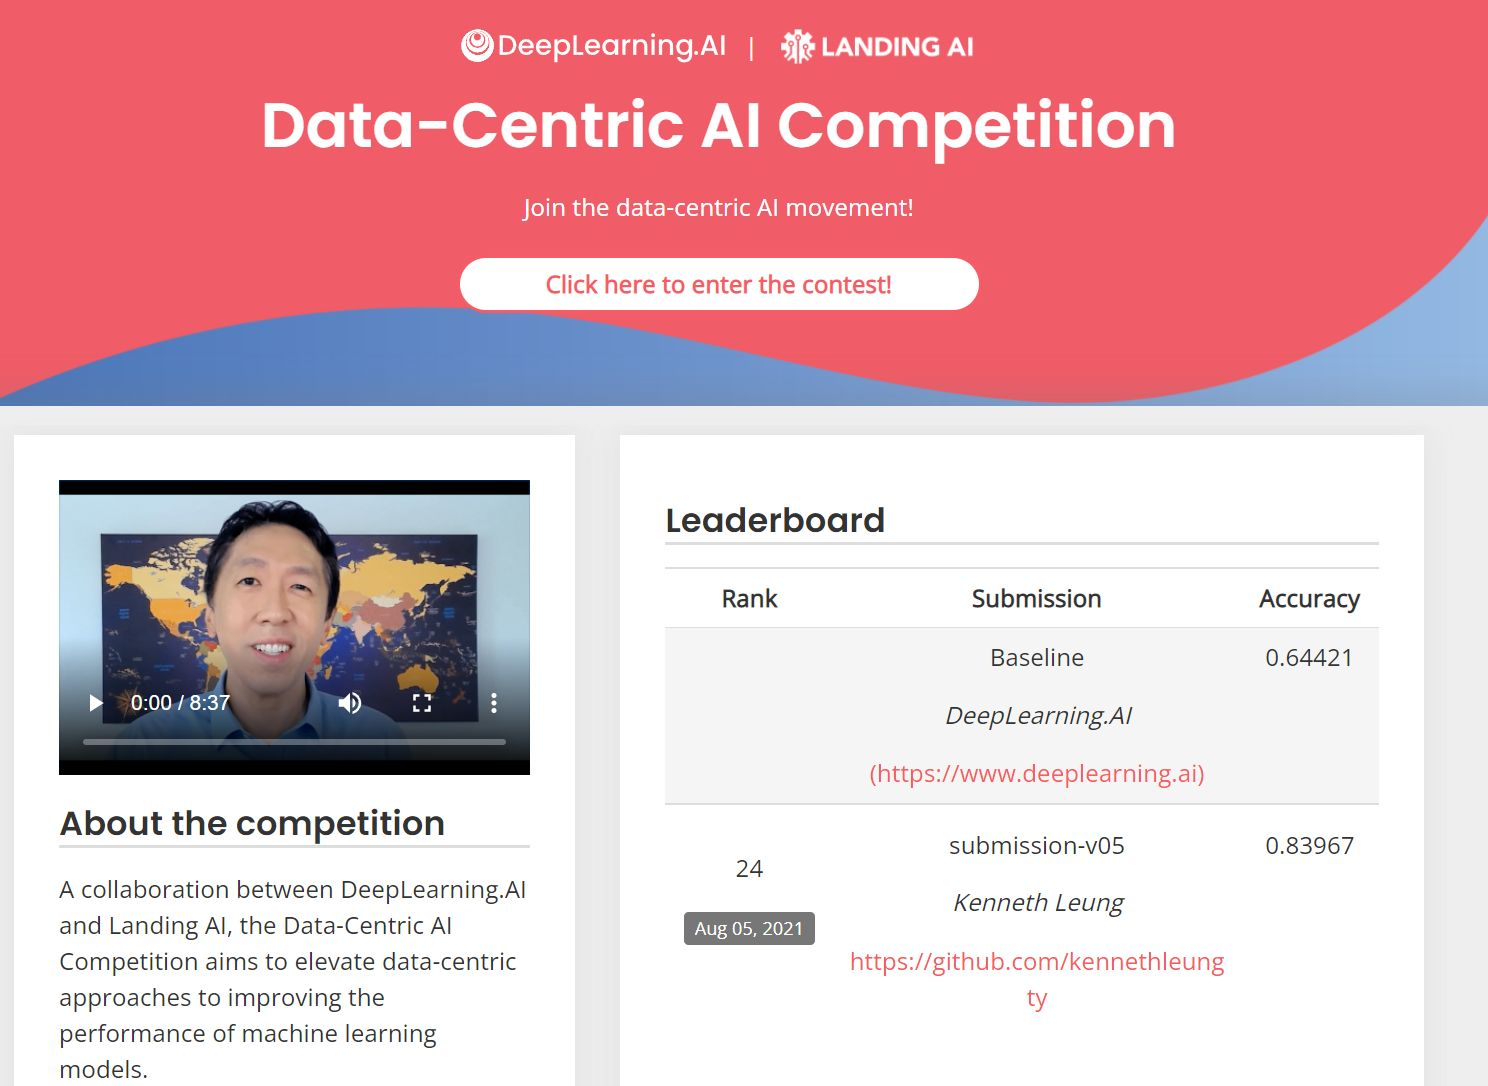  


**Link to competition website: https://https-deeplearning-ai.github.io/data-centric-comp/**

<a name="top"></a>
___
## Contents
**(1)** [Initial Setup](#initial-setup)  
**(2)** [Data Exploration](#data-exploration)  
**(3)** [Data Cleaning](#data-cleaning)  
**(4)** [Data Augmentation](#data-augmentation)  
**(5)** [References](#references)  
___

<a name="initial-setup"></a>
## 1. Initial Setup
[**^** Back to Top **^**](#top)

#### Import dependencies

In [1]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torchvision import datasets, models            # vision datasets,architectures & transforms
import torchvision.transforms as T                  # composable transforms

import imgaug as ia
from imgaug import augmenters as iaa
import os
from pathlib import Path
from glob import glob

from collections import Counter
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from scipy.ndimage.interpolation import shift
from skimage.filters import threshold_otsu

# Define locations of cleaned data to perform augmentation on
CLEAN_DATA_FOLDER = 'data/1_clean'
TRAIN_DATA = f'{CLEAN_DATA_FOLDER}/train'
VALID_DATA = f'{CLEAN_DATA_FOLDER}/val'

# Set seed
ia.seed(1)

#### View train.py file provided
This is the script that will be run to train the default model on the data we will eventually enhance

In [2]:
# View train.py file provided
!pygmentize scripts/train.py

# You can try fixing incorrect labels, adding data for side case tuning, apply
# data augmentation techniques, or use any other method to improve the data.
# You may also find it helpful to take a look at the training script to get a
# better sense of the preprocessing and model (these are held fixed). The script
# will resize all images to (32, 32) and run them through a cut off ResNet50

import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

directory = "YOUR_DIRECTORY_NAME_HERE"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)


if __name__ == "__main__":
    train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i"

#### Define paths
The raw dataset comes with two folders (train and val), with each of them having subfolders containing respective images of the Roman numerals:  

    raw/  
    │  
    └───train/ 
    │        i/
    │        ii/
    │        iii/
    │        iv/
    │        v/
    |        vi/
    |        vii/
    |        viii/
    |        ix/
    |        x/    
    └───val/ 
             i/
             ii/
             iii/
             iv/
              v/
             vi/
             vii/
             viii/
             ix/
             x/  

        


In [3]:
RAW_DATA_FOLDER = 'data/0_raw'
TRAIN_DATA = f'{RAW_DATA_FOLDER}/train'
VALID_DATA = f'{RAW_DATA_FOLDER}/val'
print(f'Train data folder: {os.listdir(TRAIN_DATA)}')
print(f'Validation data folder: {os.listdir(VALID_DATA)}')

Train data folder: ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
Validation data folder: ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


___
<a name="data-exploration"></a>
## 2. Data Exploration
[**^** Back to Top **^**](#top)

### Get number of images in raw data

In [4]:
# Count number of images in raw dataset
train_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(TRAIN_DATA) for filename in filenames])
valid_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(VALID_DATA) for filename in filenames])
print(f'Number of train images: {train_img_count}')
print(f'Number of validation images: {valid_img_count}')
print(f'Total number of images: {train_img_count + valid_img_count}')

Number of train images: 2067
Number of validation images: 813
Total number of images: 2880


### Understand dimensions and file extensions of images

In [5]:
# Get dimensions and file extensions of images in TRAIN data
dimensions = []
file_ext = []

for folder in os.listdir(TRAIN_DATA):
      for image in os.listdir(TRAIN_DATA + '/' + folder):
        img_path = os.path.join(TRAIN_DATA, folder, image)
        img_ext = image.split('.')[-1]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        try:
            dimensions.append(img.shape)
            file_ext.append(img_ext)
        except:
            print(f'NoneType image: {img_path}')
            
Counter(dimensions).most_common()

[((253, 259), 9),
 ((253, 264), 9),
 ((232, 232), 8),
 ((253, 286), 8),
 ((264, 280), 8),
 ((253, 253), 7),
 ((231, 264), 7),
 ((253, 247), 7),
 ((253, 248), 7),
 ((225, 264), 6),
 ((242, 247), 6),
 ((275, 264), 6),
 ((253, 242), 6),
 ((270, 264), 6),
 ((255, 267), 6),
 ((286, 275), 6),
 ((253, 280), 6),
 ((231, 258), 6),
 ((242, 242), 5),
 ((270, 258), 5),
 ((275, 259), 5),
 ((237, 234), 5),
 ((270, 259), 5),
 ((248, 242), 5),
 ((276, 222), 4),
 ((232, 248), 4),
 ((270, 247), 4),
 ((275, 319), 4),
 ((225, 279), 4),
 ((242, 264), 4),
 ((280, 247), 4),
 ((286, 253), 4),
 ((270, 286), 4),
 ((255, 264), 4),
 ((275, 286), 4),
 ((253, 314), 4),
 ((253, 231), 4),
 ((253, 258), 4),
 ((264, 286), 4),
 ((261, 267), 4),
 ((259, 198), 4),
 ((330, 429), 4),
 ((209, 242), 4),
 ((286, 280), 4),
 ((201, 252), 3),
 ((240, 232), 3),
 ((208, 240), 3),
 ((201, 222), 3),
 ((216, 232), 3),
 ((240, 240), 3),
 ((237, 237), 3),
 ((269, 220), 3),
 ((225, 252), 3),
 ((232, 240), 3),
 ((264, 237), 3),
 ((208, 23

In [6]:
# Get file extension
Counter(file_ext)

Counter({'png': 2067})

- Different files have different dimensions
- All files are .png format

### Visualize random subset of images

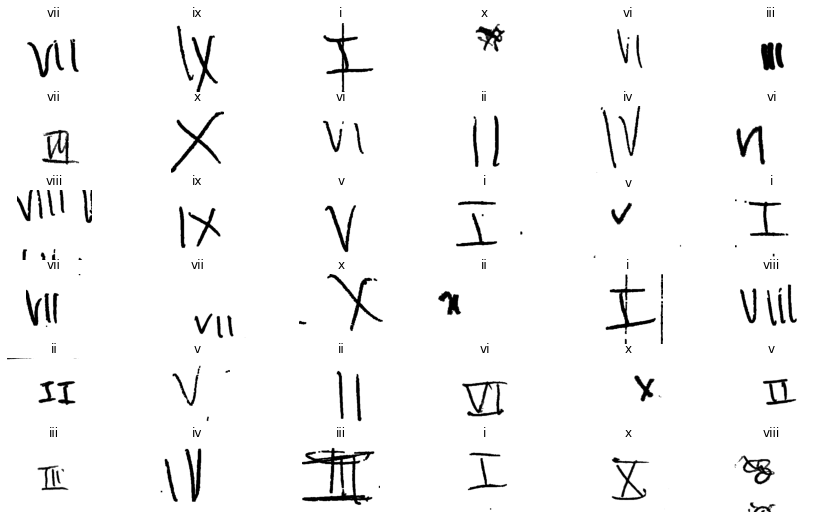

In [7]:
images, labels = [], []

for folder in os.listdir(TRAIN_DATA):
      for image in os.listdir(TRAIN_DATA + '/' + folder):
        images.append(os.path.join(TRAIN_DATA, folder, image))
        labels.append(folder)

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0

for i in range(36):
    n += 1
    random_index = random.choice(range(len(images)))
    random_label = labels[random_index]
    random_img = images[random_index]
    img = cv2.imread(random_img, cv2.IMREAD_GRAYSCALE)
    plt.subplot(6, 6, n)
    plt.axis('off')
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(random_label)

plt.show()

___
<a name="data-cleaning"></a>
## 3. Data Cleaning
[**^** Back to Top **^**](#top)

### Create new folder to store cleaned data

In [8]:
# Create new directory to store cleaned images (copy raw data)
CLEAN_DATA_FOLDER = 'data/1_clean'
TRAIN_DATA = f'{CLEAN_DATA_FOLDER}/train'
VALID_DATA = f'{CLEAN_DATA_FOLDER}/val'

try:
    shutil.copytree('data/0_raw', CLEAN_DATA_FOLDER, dirs_exist_ok=False)
    print('Created new folder')
except:
    print('Folder already exists')

Created new folder


### Rename image filenames
- Original image names are too complicated to understand e.g. adf770c6-ce5d-11eb-b317-38f9d35ea60f.png
- Rename files with simpler names so that it is easier to manage downstream 
- E.g. train_i_1.png (1st image of Roman numeric `i` in the original `train` folder)
- E.g. val_iv_21.png (21st image of Roman numeric `iv` in the original `validation` folder)

In [9]:
# Rename files in train and val sets (in new clean folder) for easier tracking
data_types = [TRAIN_DATA, VALID_DATA]

for data_type in data_types:
    for folder in os.listdir(data_type):
          for index, file in enumerate(os.listdir(data_type + '/' + folder)):
                data_type_name = data_type.split('/')[-1]
                os.rename(os.path.join(data_type, folder, file), os.path.join(data_type, folder, ''.join([str(data_type_name), '_', str(folder), '_', str(index),'.png'])))

### Visualize subset of images for specific label

In [10]:
# Setup function to display random images based on a label (for manual review) - Includes both train and valid
def show_images(label, num):
    images, labels, filenames = [], [], []

    # Add train data images
    data_folders = [TRAIN_DATA, VALID_DATA]
    
    for data_folder in data_folders:
        for folder in os.listdir(data_folder):
              for image in os.listdir(data_folder + '/' + label):
                images.append(os.path.join(data_folder, label, image))
                filenames.append(f'{image}')

    plt.figure(1, figsize=(18, 11))
    plt.axis('off')
    
    n = 0
    for i in range(num):
        n += 1
        random_index = random.choice(range(len(images)))
        random_filename = filenames[random_index]
        random_img = images[random_index]
        img = cv2.imread(random_img, cv2.IMREAD_GRAYSCALE)
        plt.subplot(np.sqrt(num), np.sqrt(num), n)
        plt.axis('off')
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        random_data_type = random_filename.split('/')[0]
        random_img_name = random_filename.split('/')[-1].split('.')[0]
        plt.title(f'{random_img_name}')

    plt.show()

<ipython-input-10-0b221fea0b5f>:24: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.sqrt(num), np.sqrt(num), n)


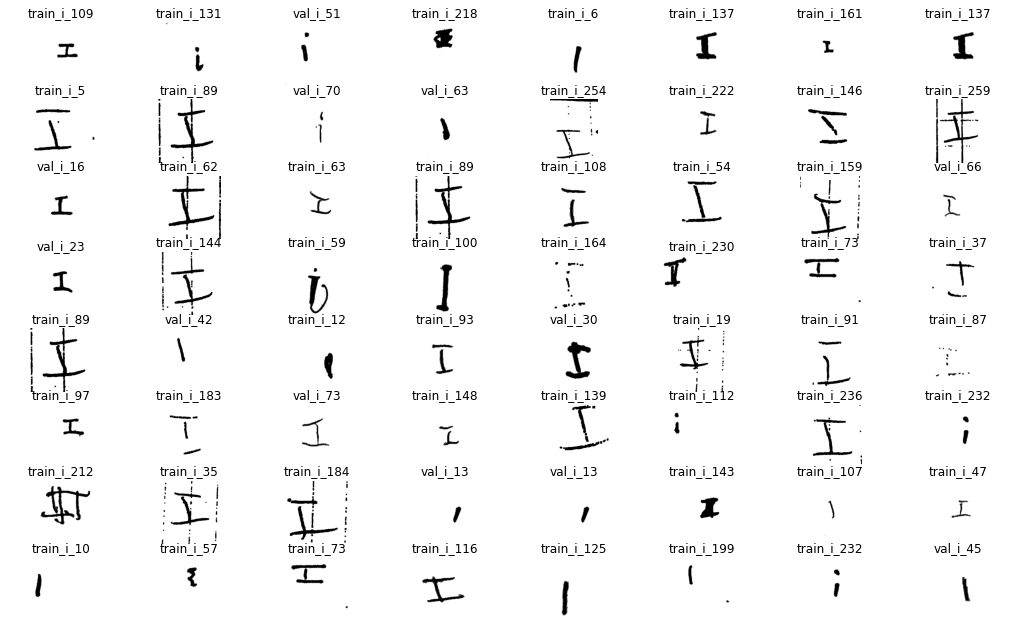

In [11]:
show_images('i', 64)

### Setup helper functions

**NOTE**: I previously setup the following functions to script the movement of images as part of data cleaning e.g. shift to different folder, deleting dirty data etc. However, I found this to be very tedious, and since the dataset is relatively small, it is much more efficient to manually shift the images using mouse 'click and drop' across the different folders. Hence, these functions are placed here for reference purposes, but were ultimately not used in the subsequent data cleaning steps.

In [12]:
# # Setup function to add file into list for deleting later
# deleted_imgs = []

# def delete_file(data_type, img_name):
#     global deleted_imgs 
#     label = img_name.split('_')[0]
#     file_path = f'{CLEAN_DATA_FOLDER}/{data_type}/{label}/{img_name}.png'
    
#     # Add file path to list to track deleted items
#     deleted_imgs = deleted_imgs + [file_path]
    
#     # Remove duplicates in list
#     deleted_imgs = list(dict.fromkeys(deleted_imgs))
    
#     # Delete file
#     try:
#         os.remove(file_path)
#         print(f'Successfully deleted {file_path}')
#     except:
#         pass

# # Setup function to move file into another folder
# # Datatype = 'train' or 'valid', Imgname (without .png) e.g. 'i_123'
# # Arguments should be in this format e.g. 'train', 'i_123', 'iii'

# def move_file(data_type, img_name, new_label):
#     old_label = img_name.split('_')[0]
#     source = f'{CLEAN_DATA_FOLDER}/{data_type}/{old_label}/{img_name}.png'
#     dest = f'{CLEAN_DATA_FOLDER}/{data_type}/{new_label}/{img_name}.png'
    
#     try:
#         shutil.move(source, dest)
#         print(f'Successfully moved {source}')
#     except:
#         pass

In [13]:
# # Files to move
# move_file('train', 'i_70', 'ii')
# move_file('train', 'i_98', 'ii')
# move_file('train', 'i_123', 'iii')

# # Add images to list for deletion
# delete_file('train', 'i_7')
# delete_file('train', 'i_75')
# delete_file('train', 'i_76') # Unclear, few pixels
# delete_file('train', 'i_122')

___
**Manual Data Cleaning was done based on the following concepts:**
- For images that are of poor quality, clearly unrecognizable or not related to Roman numerals, they are shifted out into a separate folder (`to_be_deleted`) which will not be used for the model training
- For images that contains a Roman numeral digit that is clearly different from its original label, they are shifted into the corresponding folder of the numeral that it looks like. This is based on my own visual judgement
- All these were done manually by click-dropping images across different folders

**Examples of images that are set for deletion (due to poor quality, unrecognizable digits, and image not relating to Roman numerals)**
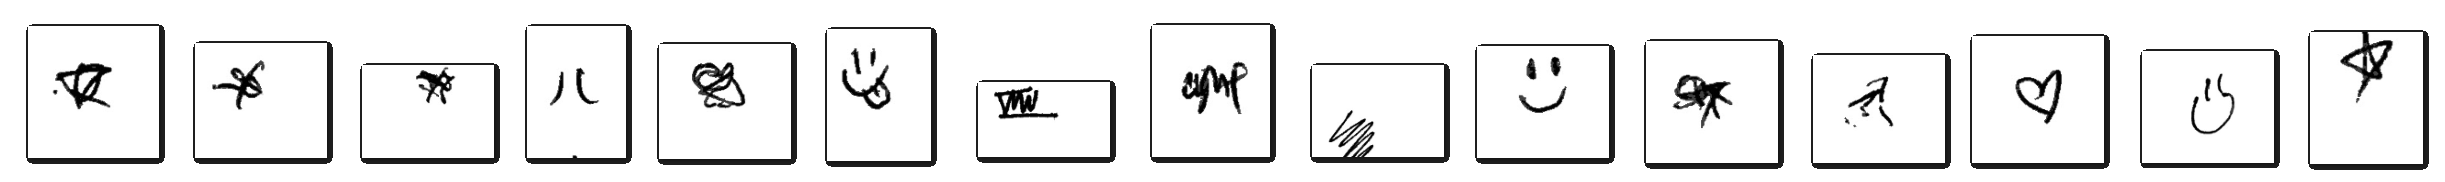

___
<a name="data-augmentation"></a>
## 4. Data Augmentation
[**^** Back to Top **^**](#top)
- As there are many lines of code from the numerous experiments conducted, I will only showcase the codes that correspond to my best submission in this section to keep things easier to comprehend

### Setup function to visualize transformation on a single image
- Includes showing histogram if needed

In [14]:
# Function to get 1 random image (from training set) and compare with transformed image
def show_single_transform(transform, show_histogram=False):
    images, filenames = [], []
    
    for folder in os.listdir(TRAIN_DATA):
          for image in os.listdir(TRAIN_DATA + '/' + folder):
            images.append(os.path.join(TRAIN_DATA, folder, image))
            filenames.append(f'{image}')
            
    random_index = random.choice(range(len(images)))
    random_filename = filenames[random_index]
    random_img = images[random_index]
    
    img_original = Image.open(random_img)
    img_original = ImageOps.grayscale(img_original) # applying greyscale method

    # Execute transformation
    try:
        img_transformed = transform(img_original)
    except:
        img_transformed = transform(images=np.asarray(img_original))
    print(f'Transformation successful')
        
    # Display images side by side
    fig = plt.figure(figsize=(14, 8))

    # show original image
    fig.add_subplot(221)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img_original, cmap=plt.get_cmap('gray'))
    fig.add_subplot(222)
    plt.title('Transformed Image')
    plt.axis('off')
    plt.imshow(img_transformed, cmap=plt.get_cmap('gray'))
    
    if show_histogram==True:
        hist_original = cv2.calcHist([np.asarray(img_original)],[0],None,[256],[0,256])
        hist_transformed = cv2.calcHist([np.asarray(img_transformed)],[0],None,[256],[0,256])
        
        fig.add_subplot(223)
        plt.title('Histogram of Original')
        plt.plot(hist_original)
        fig.add_subplot(224)
        plt.title('Histogram of Transformed')
        plt.plot(hist_transformed)
    
    plt.show();

### Create generic helper function to augment images as entire batch
Explanation:
- First mix (aka shuffle) all images from both train and validation folders together, since I noted that there were many 'good-looking' Roman numerical representations in the validation dataset
- All these images are stored in a temporary folder
- The max number of images that we can submit in the competition is 10,000. Note that our original dataset only has 2,880 images. As such, we should augment the images with specific transformation on random images in our raw dataset to top up our images to 10,000 (with 1,000 images for each of the 10 Roman numeral labels) so that our training set is maximized
- More details on these specific transformations in the following segment
- By setting a limit of 1,000 (balance number) for each label , we perform the specific transformations on the images to top up the image count
- Once we have the 10,000 images in our temp folder, we do a random train/val split so that we once again have the train folder and validation folder

In [15]:
# Mixing train and valid sets together first, perform augmentation, and then splitting
def augment_images_shuffle(label, transform, aug_version, 
                           total_size=1000, train_size=700,
                           extra_transform=None):

    # Setup relevant folder paths    
    input_folder_train = f'./{CLEAN_DATA_FOLDER}/train/{label}'
    input_folder_valid = f'./{CLEAN_DATA_FOLDER}/val/{label}'
    
    # Create temporary folder for input images specific label (with all train and val images)
    temp_folder = f'./data/2_augmented_{aug_version}/temp_{label}'
    Path(temp_folder).mkdir(parents=True, exist_ok=True)
   
    # Copy all clean images into temp folder
    input_folders = [input_folder_train, input_folder_valid]
    
    for input_folder in input_folders:
        for image in os.listdir(input_folder):
            # Copy the contents of source to destination 
            dataset_type = input_folder.split('/')[-2] # Train or valid set
            shutil.copy(f'{input_folder}/{image}', temp_folder)

    # Create output folder paths
    output_folder_train = f'./data/2_augmented_{aug_version}/train/{label}'
    output_folder_val = f'./data/2_augmented_{aug_version}/val/{label}'
    Path(output_folder_train).mkdir(parents=True, exist_ok=True)
    Path(output_folder_val).mkdir(parents=True, exist_ok=True)
        
    input_files = glob(os.path.join(temp_folder, "*.png"))
    print(f'Created temp folder: {temp_folder}')
    
    # For every image, do random transformations until hit the 1000 image mark (for each label)
    temp_folder_count = len(os.listdir(temp_folder))
    
    # Calculate number of additional images to generate to top up to 1000 images
    balance_count = total_size - temp_folder_count

    n = 0
    for i in range(balance_count):
        n += 1
        random_index = random.choice(range(len(input_files)))
        random_file = input_files[random_index]
        img_random = Image.open(random_file)
        img_random = ImageOps.grayscale(img_random)

        # Execute transformation (IAA)
        try:
            transformed_img_random = transform(img_random)
        except:
            transformed_img_random = transform(images=np.asarray(img_random))   
            
        # Perform additional morphological operation (e.g. CV2 morphs)
        if extra_transform is not None:
            transformed_img_random = extra_transform(transformed_img_random)
        
        # Convert back to PIL to save
        transformed_img_random = Image.fromarray(transformed_img_random)       
        transformed_img_random.save(f'{temp_folder}/{label}_random_{n}.png', 'PNG')
        
    # Random assign images into train and validation folders (for every label)
    full_img_list = [file for file in os.listdir(temp_folder)]
    print(len(full_img_list))
    train_list = random.sample(full_img_list, train_size)
    val_list = [x for x in full_img_list if x not in train_list]

    for file in train_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_train)
    for file in val_list:
        shutil.copy(os.path.join(temp_folder, file), output_folder_val)
    
    # Delete temporary folder
    shutil.rmtree(temp_folder, ignore_errors=True)

### Specify specify augmentation sequence for different labels

Explanation:
- I applied a set of generic augmentation steps for all images with the help of the `imgaug` library:
    - Resizing images by enlarging them to 400x400 in a bid to include more pixel details before they are shrunk later  
    - Random Gaussian blur and Additive Gaussian Noise to simulate varying quality of image
    - Random cropping (just a little bit) as there are numerous images that have plenty of white space around the Roman numeral digit
    - Linear contrast to strengthen the contrast of images slightly upwards, accompanied with random contrast adjustments (strengthen or weaken) with the use of `iaa.Multiply`
    - Introduce affine transformations to make random variations of scaling (aka zoom), translation, rotation and shear changes, whilst filling empty space with white pixels    
- To identify the images that are newly generated from the augmentation, the word `random` is added into the filename e.g. ii_random_50.png

- Beyond the generic augmentation steps, I assigned slightly different augmentations for different labels, and the key difference is based on the flip orientation (horizontal, vertical, or both)
- There are certain labels where flipping makes sense, and others where flipping does not
- For labels like `iv`, `vi`, `vii` and `viii`, flipping them horizontally or vertically will result in numbers that do **not** resemble the original digits. Hence, no random flipping changes were applied for them
- For labels like `v`, doing a horizontal flip will still allow us to get another variation of the same digit. As such, random horizontal flipping was applied as part of augmentation
- For labels like `ix`, a vertical flip will allow us to get another variation of the same digit, and thus random vertical flipping was applied
- For labels like `i`, `ii`, `iii`, `x`, both horizontal **and** vertical flipping yield new variations of the image that still resemble the original digits. As such, both random flips were applied for images that belong to these labels.
- Despite the common ['DRY'](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) rule in programming, I intentionally used repeated code templates for each augmentation sequence so that I can have granular control over the specific augmentation steps in all my experiments

In [16]:
# No flip: iv, vi, vii, viii
transform_v5a = iaa.Sequential([
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False) # Cancel random order


# Horizontal flip only: v
transform_v5b = iaa.Sequential([
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, 
                                              scale=(0.0, 0.05*255), 
                                              per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255 # Fill with white pixels
                    )
                ], random_order=False)


# Vertical flip only: ix
transform_v5c = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, 
                                              scale=(0.0, 0.05*255), 
                                              per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)


# Horizontal AND Vertical flip only: i, ii, iii, x
transform_v5d = iaa.Sequential([
                    iaa.Flipud(0.5), # Vertical flip
                    iaa.Fliplr(0.5), # Horizontal flip
                    iaa.Resize({"height": 400, "width": 400}),
                    iaa.Crop(percent=(0, 0.05)),
                    iaa.Sometimes(
                        0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.LinearContrast((1.35, 1.75)), 
                    iaa.AdditiveGaussianNoise(loc=0, 
                                              scale=(0.0, 0.05*255), 
                                              per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
                        rotate=(-20, 20),
                        shear=(-3, 3),
                        cval=255
                    )
                ], random_order=False)

Transformation successful


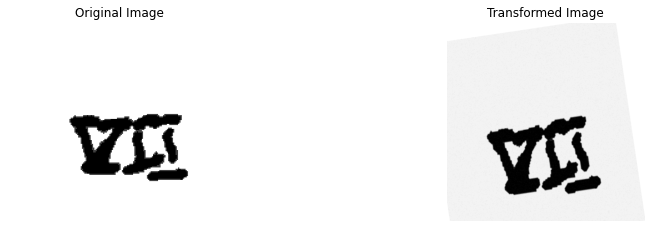

In [17]:
# Visualize transformation
show_single_transform(transform_v5b)

### Execute batch augmentation

In [18]:
# Set labels for specific augmentations
target_labels = ['i','ii','iii','iv','v','vi','vii','viii','ix','x'] # List of all labels

labels_no_flip = ['iv','vi','vii','viii'] # No flipping
labels_h_flip = ['v'] # Horizontal flip
labels_v_flip = ['ix'] # Vertical flip
labels_h_and_v_flip = ['i','ii','iii','x'] # Both horizontal and vertical flips

for target_label in target_labels:
    if target_label in labels_no_flip:
        augment_images_shuffle(label=target_label, 
                                transform=transform_v5a, # Indicate type of augmentation sequence
                                aug_version='v05', # Specify version number of experiment
                                train_size=800) # Creating a 80/20 train/val split
        
    elif target_label in labels_h_flip:
        augment_images_shuffle(label=target_label, 
                                transform=transform_v5b, 
                                aug_version='v05',
                                train_size=800)
        
    elif target_label in labels_v_flip:
        augment_images_shuffle(label=target_label, 
                                transform=transform_v5c, 
                                aug_version='v05',
                                train_size=800)
        
    else:
        augment_images_shuffle(label=target_label, 
                                transform=transform_v5d, 
                                aug_version='v05',
                                train_size=800)

Created temp folder: ./data/2_augmented_v05/temp_i
1000
Created temp folder: ./data/2_augmented_v05/temp_ii
1000
Created temp folder: ./data/2_augmented_v05/temp_iii
1000
Created temp folder: ./data/2_augmented_v05/temp_iv
1000
Created temp folder: ./data/2_augmented_v05/temp_v
1000
Created temp folder: ./data/2_augmented_v05/temp_vi
1000
Created temp folder: ./data/2_augmented_v05/temp_vii
1000
Created temp folder: ./data/2_augmented_v05/temp_viii
1000
Created temp folder: ./data/2_augmented_v05/temp_ix
1000
Created temp folder: ./data/2_augmented_v05/temp_x
1000


___
- Once completed, we will have two folders - train and val
- There will be 800 images in each of the 10 subfolders (corresponding to the 10 Roman numerals) of train set , and 200 images in eac of the 10 subfolders in the validation set
- The entire dataset is then compressed into a zip file, and submitted via CodaLab (https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6)
- As this is a data-centric competition, and **not** model-centric, there isn't a need to do the usual model training steps such as algorithm selection and hyperparameter tuning
- Experiments were tracked in a separate CSV document (see `experiment_tracker.csv`). For details on the various steps I took for each experiment, you can refer to that CSV file.

___
<a name="references"></a>
## 5. References
[**^** Back to Top **^**](#top)

- https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html
- https://pytorch.org/vision/stable/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
- https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4